In [1]:
# SECTION: Imports
# pandas fuer Tabellen, matplotlib fuer Diagramme, numpy fuer Zahlenoperationen

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# SECTION: Erste Sichtung
# CSV laden und mit head/shape/info/describe schnellen Ueberblick bekommen

df = pd.read_csv('NHLScraper/nhl.csv')
df.head()
df.shape
df.info()
df.describe(include='all')



FileNotFoundError: [Errno 2] No such file or directory: 'NHLScraper/nhl.csv'

In [ ]:
# SECTION: Daten-Checks und Hilfsfunktion
# pre_check prueft Datentypen und Wertebereiche
# initials erzeugt Team-Kuerzel aus Namen

# Falls scraper sich falsche Daten holt:

def pre_check(df):
    checks = {}
    checks["year_is_int"] = pd.api.types.is_integer_dtype(df["Year"])
    checks["wins_is_int"] = pd.api.types.is_integer_dtype(df["Wins"])
    checks["losses_is_int"] = pd.api.types.is_integer_dtype(df["Losses"])
    checks["Win_Perentage_is_float_and_between"] = pd.api.types.is_float_dtype(df["Win_Percentage"]) and df["Win_Percentage"].between(0,1).all()
    return checks
pre_check(df)

def initials(name: str) -> str:
    words = re.findall(r"[A-Za-z]+", str(name))   # Wörter extrahieren (ohne Punkte/Kommas)
    return "".join(w[0].upper() for w in words if w)

In [ ]:
# SECTION: Grundreinigung
# Leerzeichen entfernen, Jahr in int umwandeln, Prozent in 0-100, NaN in Overtime_Losses auf 0 setzen

df["Team_Name"] = df["Team_Name"].str.strip()
df["Year"] = pd.to_datetime(df["Year"], format='%Y').dt.year
df["Win_Percentage"] = df["Win_Percentage"].round(3) * 100
df["Overtime_Losses"] = df["Overtime_Losses"].fillna(0).astype(int)


In [ ]:
# SECTION: Feature Engineering
# Spiele berechnen, pro Spiel Kennzahlen, Vergleich im Jahr (z-Score), Performance-Index, Team_Initials

df["Games_played"] = df["Wins"] + df["Losses"] + df["Overtime_Losses"]
df.loc[df["Games_played"] == 0, "Games_played"] = pd.NA
df["GF_per_Game"] = (df["Goals_For"] / df["Games_played"]).round(2)
df["GA_per_Game"] = (df["Goals_Against"] / df["Games_played"]).round(2)
df["GD_per_Game"] = (df["Goal_Differential"] / df["Games_played"]).round(2)
df["GF_vergleich_im_Jahr"] = df.groupby("Year")["GF_per_Game"].transform(lambda s: (s - s.mean()) / s.std())
df["GF_vergleich_im_Jahr"] = df["GF_vergleich_im_Jahr"].round(2)
df["GA_vergleich_im_Jahr"] = df.groupby("Year")["GA_per_Game"].transform(lambda s: (s - s.mean()) / s.std())
df["GA_vergleich_im_Jahr"] = df["GA_vergleich_im_Jahr"].round(2)
df["Performance_Index"] = (df["GF_vergleich_im_Jahr"] - df["GA_vergleich_im_Jahr"]).round(2)
df["Team_Initials"] = df["Team_Name"].apply(initials)

In [ ]:
# SECTION: Validierung nach Reinigung
# Regeln pruefen, ob Werte plausibel und eindeutig sind

def validate(df):
    checks = {}

    checks["no_missing_team"] = df["Team_Name"].notna().all()
    checks["year_range_ok"] = df["Year"].between(1990, 2011).all()
    checks["wins_notnan"] = (df["Wins"] >= 0).all()
    checks["losses_notnan"] = (df["Losses"] >= 0).all()
    checks["goals_notnan"] = (df["Goals_For"] >= 0).all() and (df["Goals_Against"] >= 0).all()
    checks["team_year_unique"] = (df.duplicated(["Team_Name", "Year"]).sum() == 0)
    checks["goal_diff_consistent"] = (df["Goal_Differential"] == (df["Goals_For"] - df["Goals_Against"])).all()
    checks["goals_for_reasonable"] = df["Goals_For"].between(0, 1000).all()
    checks["goals_against_reasonable"] = df["Goals_Against"].between(0, 1000).all()
    checks["goal_diff_reasonable"] = df["Goal_Differential"].between(-500, 500).all()
    

    return checks

checks = validate(df)
checks


In [ ]:
# SECTION: Kontrolle nach der Bereinigung
# Ausgabe und Statistik pruefen

df.head()
df.shape
df.info()
df.describe(include='all')
print(df)

In [ ]:
# SECTION: Ergebnis speichern
# Sauberen Datensatz als CSV sichern

df.to_csv('nhl_cleaned.csv', index=False)

In [ ]:
# SECTION: Erste Visualisierung
# Durchschnittliche Siege pro Team, einfache Balkengrafik


df = pd.read_csv("nhl_cleaned.csv")

top_teams = (
    df.groupby("Team_Initials")["Wins"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
      .sort_values()  
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(top_teams.index, top_teams.values)  
ax.set_title("Top Teams by Average Wins")
ax.set_xlabel("Average Wins")
ax.set_ylabel("Teams")
ax.grid(axis="x", linestyle="--", alpha=0.5)  

plt.tight_layout()
plt.show()


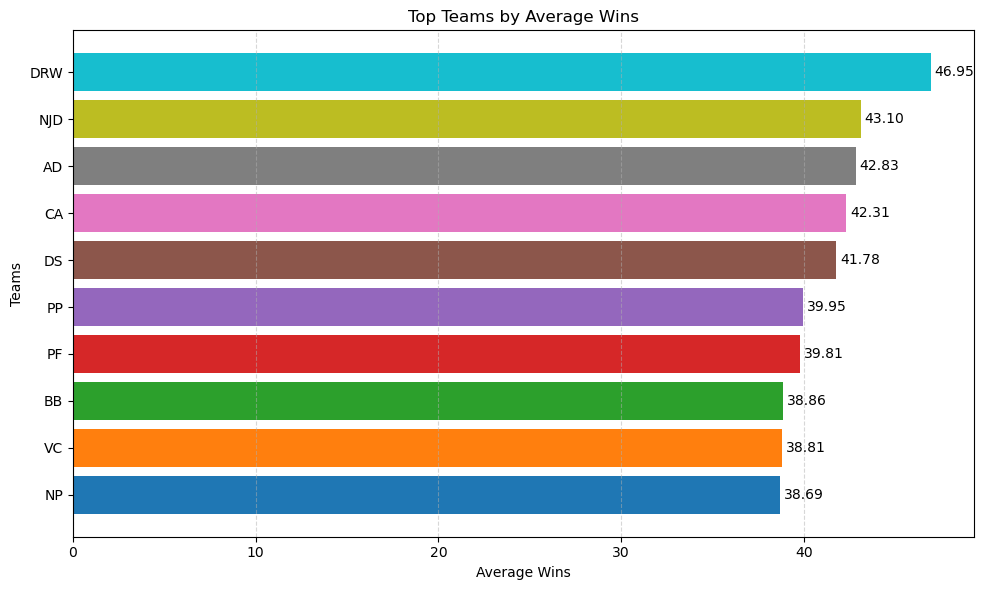

In [ ]:
# SECTION: Visualisierung mit Farben und Labels
# Gleiches wie oben, aber mit Farbschema und Wertebeschriftung

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("nhl_cleaned.csv")

top_teams = (
    df.groupby("Team_Initials")["Wins"]
      .mean()
      .sort_values(ascending=False)
      .head(10)
      .sort_values()
)

fig, ax = plt.subplots(figsize=(10, 6))


colors = plt.cm.tab10(np.linspace(0, 1, len(top_teams)))

bars = ax.barh(top_teams.index, top_teams.values, color=colors)

ax.set_title("Top Teams by Average Wins")
ax.set_xlabel("Average Wins")
ax.set_ylabel("Teams")
ax.grid(axis="x", linestyle="--", alpha=0.5)


for bar in bars:
    value = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(value + 0.2, y, f"{value:.2f}", va="center")  

plt.tight_layout()
plt.show()
